In [3]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [4]:
%run dataloader.ipynb

In [5]:
batch_size=2600
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)

In [6]:
gpu_id = 'cuda:2'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [7]:
# rnn
class RNN(torch.nn.Module):

    def __init__(self, input_dim_text, hidden_layer_size) -> None:
        super().__init__()

        self.text_rnn = torch.nn.LSTM(input_dim_text, hidden_layer_size, batch_first=True, num_layers=2, dropout=0.2)
        self.dropout = torch.nn.Dropout(0.2)
        self.linear = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x_text, text_lens):
        batch_size = x_text.shape[0]

        interm_states_text, _ = self.text_rnn(x_text)
        final_state_text = interm_states_text[torch.arange(batch_size), text_lens - 1, :]

        h = self.dropout(final_state_text)
        return self.linear(h)

step error


/tmp/ipykernel_3366178/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3366178/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3366178/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

1 0.692065417766571
dev error:  0.6919435262680054
2 0.6905661821365356
dev error:  0.6907120943069458
3 0.6880674958229065
dev error:  0.6891809701919556
4 0.6856358647346497
dev error:  0.686822772026062
5 0.679785966873169
dev error:  0.682891845703125
6 0.6718578338623047
dev error:  0.6774467825889587
7 0.6575726270675659
dev error:  0.6776332855224609
8 0.6541206240653992
dev error:  0.6844279766082764
9 0.6379340291023254
dev error:  0.6718072295188904
10 0.6418887972831726
dev error:  0.6677404046058655
11 0.6463479399681091
dev error:  0.6648816466331482
12 0.6285539269447327
dev error:  0.6678211092948914
13 0.6202729344367981
dev error:  0.6611857414245605
14 0.636061429977417
dev error:  0.6592851877212524
15 0.6288414597511292
dev error:  0.6582461595535278
16 0.6340794563293457
dev error:  0.6600237488746643
17 0.6277818083763123
dev error:  0.6678066253662109
18 0.629325807094574
dev error:  0.6586998105049133
19 0.6331994533538818
dev error:  0.6582891345024109
20 0.637

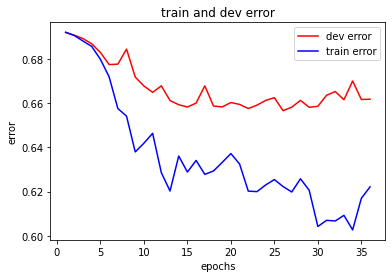

best model after 26 epochs with dev set error 0.6565871834754944


In [8]:
# input features
###
idxs_text = torch.arange(300) # text, 300

device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
model = RNN(input_dim_text=300, hidden_layer_size=256)
model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.002)
epochs = 500
patience = 10

print('step', 'error')
dev_errors = []
best_dev_error = np.inf
errors = []
num_bad_epochs = 0
num_epochs = 0
best_epoch = 0
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        optimiser.zero_grad()
        output = model(x_p[:, :, idxs_text], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        model.eval()
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0):
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            dev_output = model(x_p[:, :, idxs_text], x_p_len)
            dev_error = torch.nn.functional.binary_cross_entropy_with_logits(dev_output, y)
        dev_errors.append(float(dev_error))
        print('dev error: ', float(dev_error))

    if dev_error < best_dev_error:
        num_bad_epochs = 0
        best_dev_error = dev_error
        best_epoch = epoch
        torch.save(model, 'punchline_net_text.pth')
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            num_epochs = epoch
            break

plt.plot(range(1, num_epochs+1), dev_errors, 'r', label='dev error')
plt.plot(range(1, num_epochs+1), errors, 'b', label='train error')
plt.title('train and dev error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()
plt.show()

print('best model after {} epochs with dev set error {}'.format(best_epoch, best_dev_error))
model = torch.load('punchline_net_text.pth')

In [12]:
hid_humor_t = {}
hid_humor_f = {}
hid_nonhumor_t = {}
hid_nonhumor_f = {}

with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid, x_p_len=map(lambda x: x.to(device), batch)
        output = model(x_p[:, :, idxs_text], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        scaled_outputs = torch.sigmoid(output)
        predictions = (scaled_outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
        for j, id in enumerate(hid.detach().tolist()):
            if predictions[j] == 1 and y[j] == 1:
                hid_humor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 1 and y[j] == 0:
                hid_humor_f[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 0:
                hid_nonhumor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 1:
                hid_nonhumor_f[id] = scaled_outputs[j].detach().tolist()[0]
            else:
                print('something is wrong')
    acc = matches / total
    print('test error: ', float(error))
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_3366178/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3366178/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3366178/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

test error:  0.6393314003944397
test accuracy: 65.41%


In [13]:
print(len(hid_humor_t))
print(len(hid_nonhumor_t))
print(len(hid_humor_f))
print(len(hid_nonhumor_f))

language_sdk=load_pickle("language_sdk.pkl")

sorted_humor_t = {k: v for k, v in sorted(hid_humor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_t = {k: v for k, v in sorted(hid_nonhumor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_humor_f = {k: v for k, v in sorted(hid_humor_f.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_f = {k: v for k, v in sorted(hid_nonhumor_f.items(), key=lambda item: item[1], reverse=True)}

for hid, output in list(sorted_humor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_humor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])

353
288
202
137
so had the graduate heard the right one word maybe he would have ended up onstage oh i don't know maybe with these two
and as the saying goes when angry you will make the best speech you will ever regret
no slouching no pants hanging down none of that stuff
this mouthing behavior on the right was really her way of saying to him hey look how big i am or you know my what big teeth you have
if you want to remember one thing it's that you can't fetch the coffee if you're dead

oh let me kind of tell you a funny little play bit
it's also good news if you want to browse for illegal pornography and if you want to buy and sell drugs with impunity
but on the other side of that predatory gaze is a female husky in a play bow wagging her tail
so when you're watching a movie and a phone rings it's not actually ringing
ok but don't say my name like that

many of you have probably heard about so i'll just say briefly that is a tool that allows researchers to edit genes very precisely 